In [1]:
import pandas as pd
import datetime
%pylab inline
import cartopy.crs as ccrs
import matplotlib.dates as mdates
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = 'combined_storms.csv'

In [3]:
storms = pd.read_csv(path)
print(storms.keys())

Index([u'storm_id', u'scan', u'uid', u'area', u'grid_x', u'grid_y',
       u'isolated', u'lat', u'lon', u'max', u'max_alt', u'time', u'vol',
       u'file', u'kdp_pct', u'kdp_pet', u'zdr_pct', u'zdr_pet', u'zhh_pct',
       u'zhh_pet'],
      dtype='object')


In [4]:
# 0.5 km resolution: need to divide grid_x and grid_y by 2
storms['dist_from_radar'] = sqrt(((storms['grid_x']-400.0)/2).pow(2) + ((storms['grid_y']-400.0)/2).pow(2))

def cell_month(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.month

def cell_year(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.year

def cell_day(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.day

def cell_hour(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.hour

def cell_life(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[-1], '%Y-%m-%d %H:%M:%S') -
                   datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.seconds/60.0

def cell_distance(y):
    xdiff = ((y['grid_x'][1:]-y['grid_x'][:-1])/2).pow(2)
    ydiff = ((y['grid_y'][1:]-y['grid_y'][:-1])/2).pow(2)
    delta_dist = np.sqrt(xdiff + ydiff)
    return np.sum(delta_dist)

def heading(y):
    angle = np.arctan2(y['grid_x'].values[-1]-y['grid_x'].values[0], 
                     y['grid_y'].values[-1]-y['grid_y'].values[0])
    return angle*180/np.pi

def initiation_time(y):
    return datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S')

def initiation_lat(y):
    return y['lat'].values[0]

def initiation_lon(y):
    return y['lon'].values[0]

def azimuth(y):
    return np.arctan2(y['grid_x'].values[0]-400.0,
                      y['grid_y'].values[0]-400.0)

In [5]:
storms.set_index(['storm_id', 'uid'], inplace=True)
cells = storms.groupby(level=['storm_id', 'uid'])
storms['life_iso'] = cells.apply(lambda x: np.all(x['isolated']))
storms['nscans'] = cells.size()
storms['life_time'] = cells.apply(cell_life)
storms['init_time'] = cells.apply(initiation_time)
storms['lat_init'] = cells.apply(initiation_lat)
storms['lon_init'] = cells.apply(initiation_lon)
storms['heading'] = cells.apply(heading)
storms['month'] = cells.apply(cell_month)
storms['hour'] = cells.apply(cell_hour)
storms['year'] = cells.apply(cell_year)
storms['day'] = cells.apply(cell_day)
storms['dist'] = cells.apply(cell_distance)
storms['azimuth'] = cells.apply(azimuth)

In [6]:
storms['dist_from_radar'] = sqrt(((storms['grid_x']-400.0)/2).pow(2) + ((storms['grid_y']-400.0)/2).pow(2))
storms['max_dist'] = cells.apply(lambda x:x['dist_from_radar'].max())      

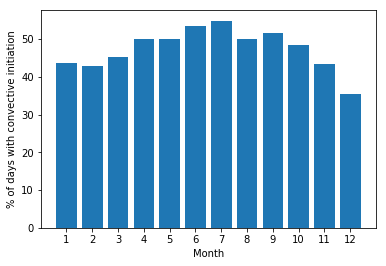

In [82]:
y = np.array(storms['year'][storms['life_iso'] == True].values)
m = np.array(storms['month'][storms['life_iso'] == True].values)
d = np.array(storms['day'][storms['life_iso'] == True].values)
the_tuples = np.array(list(zip(y,m,d)))

day_hist = np.zeros(12)
num_days = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
for i in range(1,13):
    day_hist[i-1] = len(np.unique(the_tuples[m == i]))
plt.bar(range(1,13), 100*day_hist/num_days/2)
plt.xlabel('Month')
plt.xticks(range(1,13))
plt.ylabel('% of days with convective initiation')

In [ ]:
day2_hist = np.zeros(31)
for i in range (1,32):
    day2_hist[i-1] = len(the_tuples[np.logical_and.reduce((y == 2016, m == 7, d == i))])

plt.figure(figsize=(10,5))
plt.bar(range(1,32), day2_hist)
plt.xlabel('Day')
plt.xticks(range(1,32))
plt.ylabel('# of cells in July 2015 on day')

In [51]:
storms[storms['isolated'] == True]

scan   area   grid_x   grid_y  isolated      lat      lon  \
storm_id uid                                                              
110      7       1   9.75  775.436    2.795      True  27.6733 -93.1751   
111      13      3   9.25  375.730  795.541      True  31.2525 -95.2051   
         13      4  15.75  378.254  795.762      True  31.2526 -95.1946   
149      0       0  51.25  545.088   29.537      True  27.8061 -94.3417   
         3       0  11.00  487.091  234.932      True  28.7292 -94.6326   
         8       0  18.75  428.907  263.973      True  28.8603 -94.9298   
         0       1  66.25  548.170   31.185      True  27.8105 -94.3264   
         12      1  16.50  747.258  201.697      True  28.5698 -93.3021   
         8       1  20.50  435.805  263.390      True  28.8557 -94.8939   
         14      1  22.00  166.750  276.500      True  28.9090 -96.2756   
         0       2  89.25  549.132   29.056      True  27.8015 -94.3214   
         16      2  11.00  314.659  234.682      True  28.7293 -95.5146   
         8       2  20.25  437.049  263.926      True  28.8602 -94.8888   
         14      2  30.00  166.150  277.500      True  28.9179 -96.2808   
         18      3  26.00  623.760   51.673      True  27.9022 -93.9391   
         19      3  21.00  122.202  220.095      True  28.6549 -96.5033   
         16      3   8.50  315.824  236.676      True  28.7383 -95.5095   
         19      4  42.25  125.367  227.130      True  28.6866 -96.4883   
         8       4  12.00  451.104  261.562      True  28.8511 -94.8169   
171      262    31  10.75  406.721  453.860      True  29.7147 -95.0425   
174      30     10  12.75   74.490  724.314      True  30.9179 -96.7873   
         36     14  20.00   67.238   84.675      True  28.0447 -96.7752   
178      12      1  11.25  225.778  451.044      True  29.6982 -95.9795   
         20      3   8.75  237.457  294.029      True  28.9926 -95.9167   
         21      3  11.75  398.319  331.702      True  29.1661 -95.0890   
179      4       0  16.75  348.194  238.701      True  28.7477 -95.3454   
         7       0  24.00  390.594  361.781      True  29.3010 -95.1251   
         55      3  31.00  410.185  370.903      True  29.3415 -95.0272   
         56      3  11.25  189.089  418.733      True  29.5529 -96.1694   
         55      4  37.25  415.349  389.966      True  29.4269 -95.0013   
...            ...    ...      ...      ...       ...      ...      ...   
2598     87     32  15.00  795.983  249.267      True  28.7775 -93.0471   
         100    33  49.25  581.244   42.239      True  27.8590 -94.1583   
         100    34  60.75  586.498   48.309      True  27.8858 -94.1326   
         159    39   9.75  746.590   30.821      True  27.8010 -93.3150   
         175    41  26.25  632.143    3.571      True  27.6861 -93.9008   
         180    43  10.75  740.674    3.512      True  27.6801 -93.3475   
         195    43  18.00  787.194  242.917      True  28.7512 -93.0938   
         206    44  30.50  734.418  258.926      True  28.8269 -93.3644   
         213    44  38.25   10.327  739.464      True  30.9806 -97.1241   
         216    45  22.75  795.330   71.473      True  27.9774 -93.0677   
         218    45  11.50  684.609   90.804      True  28.0746 -93.6264   
         213    45  14.75   19.390  746.763      True  31.0173 -97.0776   
         231    46  12.25  798.184   83.061      True  28.0311 -93.0514   
2599     134    13   9.00  670.556  149.917      True  28.3406 -93.6943   
         212    26   8.25  497.242  192.364      True  28.5357 -94.5823   
         223    29   8.50  627.676  428.824      True  29.5971 -93.8996   
         236    34  12.00  113.167   41.417      True  27.8497 -96.5382   
         251    42   9.25  285.784  465.405      True  29.7629 -95.6692   
         252    42  10.75  262.558  474.349      True  29.8028 -95.7887   
         251    43   9.50  290.105  468.500      True  29.7765 -95.6486   
         252    43  11.00  267.750  478

In [83]:
counts70, bins70 = np.histogram(storms['life_time'][np.logical_and(storms['dist_from_radar'] < 70.0,
                                                                storms['isolated'] == True)], bins=range(1,200,10))
counts150, bins150 = np.histogram(storms['life_time'][np.logical_and(storms['dist_from_radar'] < 150.0,
                                                                storms['isolated'] == True)], bins=range(1,200,10))
counts200, bins200 = np.histogram(storms['life_time'][np.logical_and(storms['dist_from_radar'] < 200.0,
                                                                storms['isolated'] == True)], bins=range(1,200,10))
counts_july, bins_july = np.histogram(storms['life_time'][np.logical_and(storms['month'] == 7,
                                                                storms['isolated'] == True)], bins=range(1,200,10))
counts_jan, bins_jan = np.histogram(storms['life_time'][np.logical_and(storms['month'] == 1,
                                                                storms['isolated'] == True)], bins=range(1,200,10))
counts_oct, bins_oct = np.histogram(storms['life_time'][np.logical_and(storms['month'] == 12,
                                                                storms['isolated'] == True)], bins=range(1,200,10))

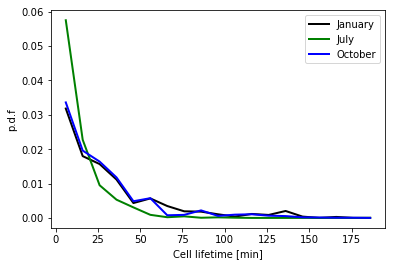

In [37]:
plt.plot((bins_jan[1:]+bins_jan[:-1])/2.0, counts_jan.astype(float)/np.sum(counts_jan)/10, linewidth=2, color='k')
plt.plot((bins_july[1:]+bins_july[:-1])/2.0, counts_july.astype(float)/np.sum(counts_july)/10, linewidth=2, color='g')
plt.plot((bins_oct[1:]+bins_oct[:-1])/2.0, counts_oct.astype(float)/np.sum(counts_oct)/10, linewidth=2, color='b')
plt.xlabel('Cell lifetime [min]')
plt.ylabel('p.d.f')
plt.legend(['January', 'July', 'October'])

In [34]:
counts_july, bins_july = np.histogram(storms['dist'][np.logical_and(storms['month'] == 7,
                                                                storms['isolated'] == True)], bins=range(1,200,10))
counts_jan, bins_jan = np.histogram(storms['dist'][np.logical_and(storms['month'] == 1,
                                                                storms['isolated'] == True)], bins=range(1,200,10))
counts_oct, bins_oct = np.histogram(storms['dist'][np.logical_and(storms['month'] == 12,
                                                                storms['isolated'] == True)], bins=range(1,200,10))

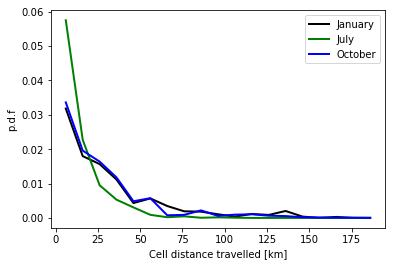

In [38]:
plt.plot((bins_jan[1:]+bins_jan[:-1])/2.0, counts_jan.astype(float)/np.sum(counts_jan)/10, linewidth=2, color='k')
plt.plot((bins_july[1:]+bins_july[:-1])/2.0, counts_july.astype(float)/np.sum(counts_july)/10, linewidth=2, color='g')
plt.plot((bins_oct[1:]+bins_oct[:-1])/2.0, counts_oct.astype(float)/np.sum(counts_oct)/10, linewidth=2, color='b')
plt.xlabel('Cell distance travelled [km]')
plt.ylabel('p.d.f')
plt.legend(['January', 'July', 'October'])

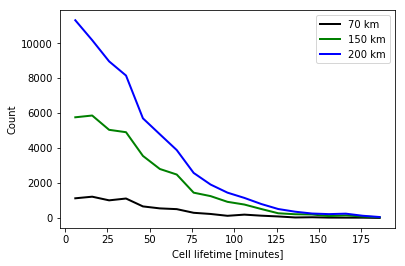

In [84]:
plt.plot((bins70[1:]+bins70[:-1])/2.0, counts70, linewidth=2, color='k')
plt.plot((bins150[1:]+bins150[:-1])/2.0, counts150, linewidth=2, color='g')
plt.plot((bins200[1:]+bins200[:-1])/2.0, counts200, linewidth=2, color='b')
plt.xlabel('Cell lifetime [minutes]')
plt.ylabel('Count')
plt.legend(['70 km', '150 km', '200 km'])

In [151]:
print(storms['time'][np.logical_and(storms['life_time'] > 90, storms['isolated'] == True)])

storm_id  uid
221       31     2015-01-11 05:54:54
          31     2015-01-11 06:12:36
223       93     2015-01-11 18:04:46
          93     2015-01-11 18:09:44
          93     2015-01-11 18:14:56
          93     2015-01-11 18:30:37
          93     2015-01-11 18:35:48
          93     2015-01-11 18:56:40
          93     2015-01-11 19:01:36
292       171    2015-02-01 23:42:27
351       26     2015-02-20 18:50:30
          26     2015-02-20 19:03:45
          26     2015-02-20 19:12:28
          26     2015-02-20 19:21:04
          26     2015-02-20 20:34:09
          26     2015-02-20 21:01:07
358       14     2015-02-21 19:47:12
          14     2015-02-21 19:52:07
          14     2015-02-21 21:41:00
          14     2015-02-21 22:01:27
          14     2015-02-21 22:09:41
374       8      2015-03-01 18:37:09
378       17     2015-03-02 09:37:50
459       1      2015-03-19 21:50:35
          1      2015-03-19 22:20:29
464       7      2015-03-20 21:11:55
          7      2015-03

In [78]:
hour_of_day = [time.hour for time in storms['init_time'][storms['isolated'] == True]]
month_of_year = [time.month for time in storms['init_time'][storms['isolated'] == True]]
day_of_year = [time.day for time in storms['init_time'][storms['isolated'] == True]]

day_hist = np.zeros(12)
for months in range(1,13):
    print(np.unique(day_of_year))
    day_hist[months-1] = len(np.unique(day_of_year[month_of_year == months]))
hist, bins = np.histogram(hour_of_day, range(0,25))
print(day_hist)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 

<Container object of 12 artists>

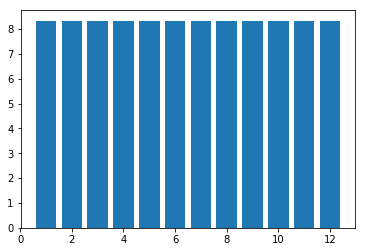

In [30]:
plt.bar(range(1,13), 100*day_hist/np.sum(day_hist))

[2134 1260 1015  879 1089 1365 1484 2422 2574 3777 4210 4388 3889 3954 3851
 4221 4740 5661 5742 5070 4932 4255 4344 3026]


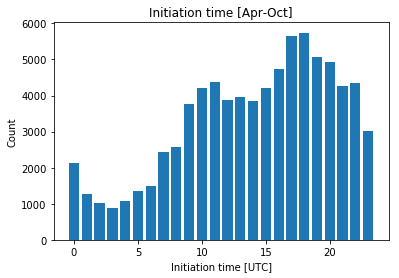

In [18]:
print(hist)
plt.bar(bins[:-1],hist)
plt.xlabel('Initiation time [UTC]')
plt.ylabel('Count')
plt.title('Initiation time [Apr-Oct]')

[ 1479  1122  1341  1896  2339 16814 16989 17659 16493  6751  2989  2055]


([<matplotlib.axis.XTick at 0x1bf2f780>,
 <a list of 12 Text xticklabel objects>)

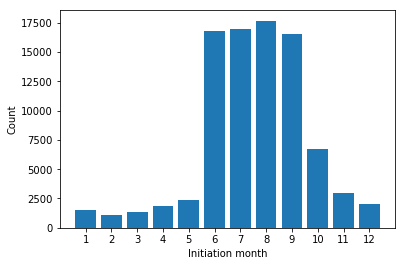

In [12]:
hist, bins = np.histogram(month_of_year, range(1,14))
print(hist)
plt.bar(bins[:-1],hist)
plt.xlabel('Initiation month')
plt.ylabel('Count')
plt.xticks(range(1,13))

In [13]:
storms.replace('--', 'nan', regex=True, inplace=True)
storms['kdp_pet'] = storms['kdp_pet'].apply(lambda x: float(x))
print(storms['zdr_pet'][storms['zdr_pet'] == '--'])
storms['zdr_pet'] = storms['zdr_pet'].apply(lambda x: float(x))
#storms['datenum'] = storms['time'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S'))
#kdp = storms['kdp_pet']

Series([], Name: zdr_pet, dtype: object)


NameError: global name 'time' is not defined

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


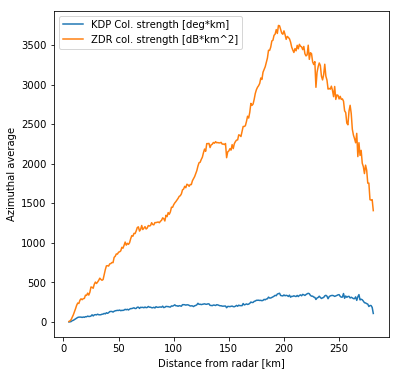

In [14]:
## Azimuthal average of kdp, zdr column strength
dist_radar_bins = np.arange(0,301,1)
kdp_ave = np.zeros(len(dist_radar_bins)-1)
zdr_ave = np.zeros(len(dist_radar_bins)-1)
for i in range(len(dist_radar_bins)-1):
    kdp_ave[i] = np.nanmean(storms['kdp_pet'][np.logical_and(storms['dist_from_radar'] >= dist_radar_bins[i],
                                                             storms['dist_from_radar'] < dist_radar_bins[i+1])])
    zdr_ave[i] = np.nanmean(storms['zdr_pet'][np.logical_and(storms['dist_from_radar'] >= dist_radar_bins[i],
                                                             storms['dist_from_radar'] < dist_radar_bins[i+1])])
dist_radar_bins = (dist_radar_bins[:-1]+dist_radar_bins[1:])/2
kdp_bias = interp1d(dist_radar_bins, kdp_ave, fill_value='extrapolate')
zdr_bias = interp1d(dist_radar_bins, zdr_ave, fill_value='extrapolate')
plt.figure(figsize=(6,6))
plt.plot(dist_radar_bins, kdp_ave)
plt.plot(dist_radar_bins, zdr_ave)
plt.xlabel('Distance from radar [km]')
plt.ylabel('Azimuthal average')
plt.legend(['KDP Col. strength [deg*km]', 'ZDR col. strength [dB*km^2]'])

In [15]:
storms['kdp_bias'] = storms['dist_from_radar'].apply(kdp_bias)
storms['zdr_bias'] = storms['dist_from_radar'].apply(zdr_bias)
storms['kdp_pet_corrected'] = storms['kdp_pet'].sub(storms['kdp_bias'])
storms['zdr_pet_corrected'] = storms['zdr_pet'].sub(storms['zdr_bias'])

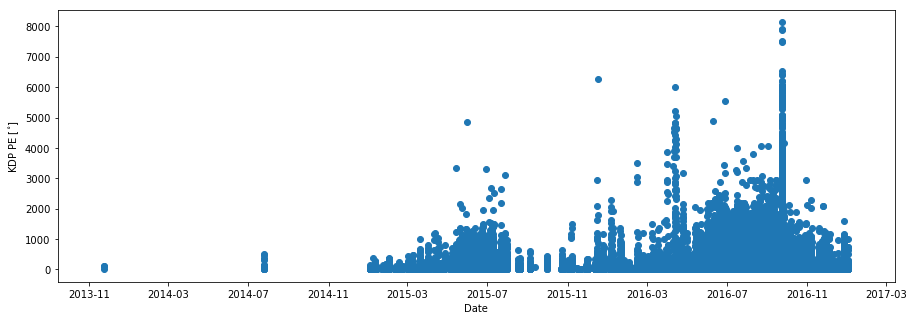

In [180]:
plt.figure(figsize=(15,5))
plt.scatter(np.array(storms['datenum'][storms['isolated'] == True].values),
            np.array(storms['kdp_pet'][storms['isolated'] == True].values))
plt.xlabel('Date')
plt.ylabel('KDP PE [$^{\circ}$]')

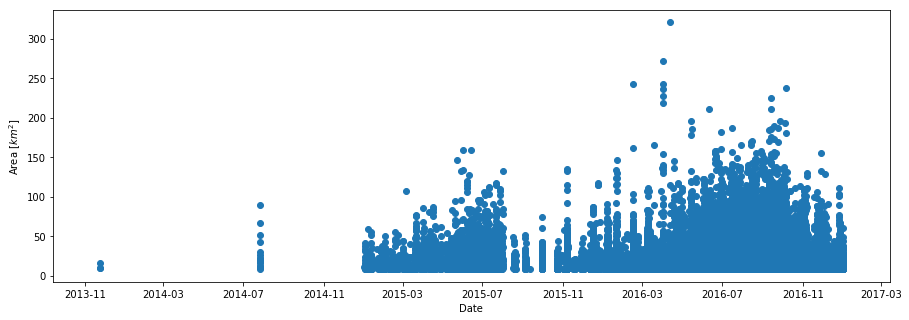

In [164]:
plt.figure(figsize=(15,5))
plt.scatter(np.array(storms['datenum'][storms['isolated'] == True].values),
            np.array(storms['area'][storms['isolated'] == True].values))
plt.xlabel('Date')
plt.ylabel('Area [$km^{2}$]')

(0, 20000)

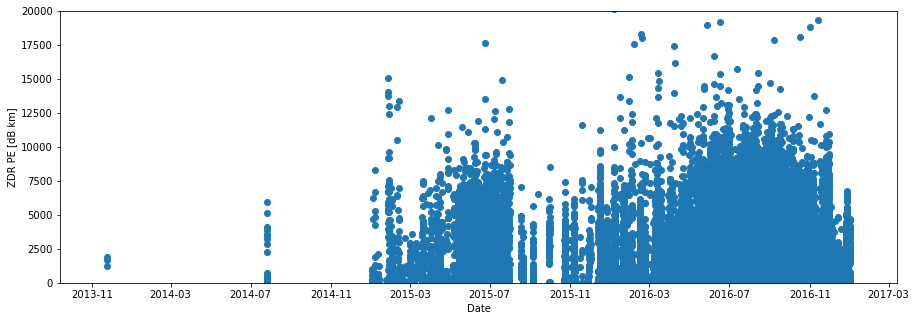

In [179]:
plt.figure(figsize=(15,5))
plt.scatter(np.array(storms['datenum'][storms['isolated'] == True].values),
            np.array(storms['zdr_pet'][storms['isolated'] == True].values))
plt.xlabel('Date')
plt.ylabel('ZDR PE [dB km]')
plt.ylim([0,20000])

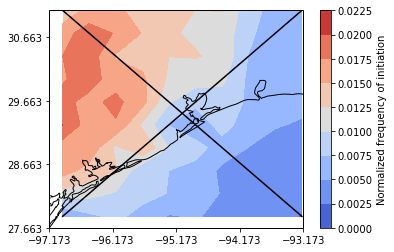

In [19]:
counts, bins_x, bins_y = np.histogram2d(storms['lon_init'][storms['isolated'] == True],
                                        storms['lat_init'][storms['isolated'] == True], bins=10)
counts = counts/counts.sum()
x, y = np.meshgrid((bins_x[0:-1]+bins_x[1:])/2, (bins_y[0:-1]+bins_y[1:])/2)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plt.contourf(x, y, counts, cmap='coolwarm')
plt.xlim([x[0,0], x[-1,-1]])
plt.ylim([y[0,0], y[-1,-1]])
ax.set_xticks(np.arange(bins_x[0], bins_x[-1],1))
ax.set_yticks(np.arange(bins_y[0], bins_y[-1],1))
ax2 = plt.colorbar()
ax2.set_label('Normalized frequency of initiation')
# Generate dividing lines
# Point slope form y - b = m(x - a)
right_diagonal_a = x[0,0]
right_diagonal_b = y[0,0]
right_diagonal_m = (y[-1,-1]-y[0,0])/(x[-1,-1]-x[0,0])
left_diagonal_a = x[-1,0]
left_diagonal_b = y[-1,0]
left_diagonal_m = (y[0,-1]-y[-1,0])/(x[0,-1]-x[-1,0])
x_vec = np.array([x[0,0], x[-1,-1]])
plt.plot(x_vec, right_diagonal_m*(x_vec-right_diagonal_a)+right_diagonal_b, color='k')
plt.plot(x_vec, left_diagonal_m*(x_vec-left_diagonal_a)+left_diagonal_b, color='k')

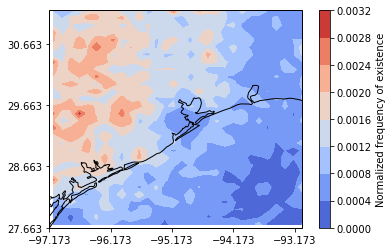

In [91]:
counts, bins_x, bins_y = np.histogram2d(storms['lon'][storms['isolated'] == True],
                                        storms['lat'][storms['isolated'] == True], bins=30)
counts = counts/counts.sum()
x, y = np.meshgrid((bins_x[0:-1]+bins_x[1:])/2, (bins_y[0:-1]+bins_y[1:])/2)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plt.contourf(x, y, counts, cmap='coolwarm')
plt.xlim([x[0,0], x[-1,-1]])
plt.ylim([y[0,0], y[-1,-1]])
ax.set_xticks(np.arange(bins_x[0], bins_x[-1],1))
ax.set_yticks(np.arange(bins_y[0], bins_y[-1],1))
ax2 = plt.colorbar()
ax2.set_label('Normalized frequency of existence')

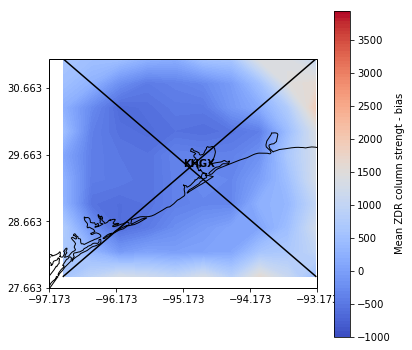

In [27]:
the_mean = np.zeros((len(bins_x)-1, len(bins_y)-1))
houston_lat = 29.0+28.0/60+19.0/3600
houston_lon = -95.0-4.0/60-45.0/3600

for i in range(len(bins_x)-1):
    for j in range(len(bins_y)-1):
        the_indicies = np.logical_and.reduce((storms['lon'].values >= bins_x[i], storms['isolated'].values == True,
                                                       storms['lon'].values <= bins_x[i+1], storms['lat'].values >= bins_y[j],
                                                       storms['lat'].values <= bins_y[j+1]))
        the_mean[i,j] = np.nanmean(storms['zdr_pet_corrected'][the_indicies].values)                

x, y = np.meshgrid((bins_x[0:-1]+bins_x[1:])/2, (bins_y[0:-1]+bins_y[1:])/2)
plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plt.contourf(x, y, the_mean, cmap='coolwarm', levels=np.arange(-1000,4000,50))
plt.text(houston_lon-0.1, houston_lat, 'KHGX', fontweight='bold')
plt.xlim([x[0,0], x[-1,-1]])
plt.ylim([y[0,0], y[-1,-1]])
ax.set_xticks(np.arange(bins_x[0], bins_x[-1],1))
ax.set_yticks(np.arange(bins_y[0], bins_y[-1],1))
ax2 = plt.colorbar()
ax2.set_label('Mean ZDR column strength - bias')
plt.plot(x_vec, right_diagonal_m*(x_vec-right_diagonal_a)+right_diagonal_b, color='k')
plt.plot(x_vec, left_diagonal_m*(x_vec-left_diagonal_a)+left_diagonal_b, color='k')

In [ ]:
degree_spacing = 3
bins = np.arange(-180, 180, degree_spacing)
hist1, bins = np.histogram(storms['heading'][np.logical_and(np.logical_and(storms['month'] == 1,
                                                           storms['life_time'] > 0), storms['isolated'] == True)],
                          bins=bins)
hist2, bins = np.histogram(storms['heading'][np.logical_and(np.logical_and(storms['month'] == 7,
                                                           storms['life_time'] > 0), storms['isolated'] == True)],
                          bins=bins)
hist3, bins = np.histogram(storms['heading'][np.logical_and(np.logical_and(storms['month'] == 10,
                                                           storms['life_time'] > 0), storms['isolated'] == True)],
                          bins=bins)
plt.figure(figsize=(7,7))
ax = plt.subplot(1,1,1, projection='polar')
ax.plot(bins[:-1]*np.pi/180, hist1.astype(float)/np.sum(hist1)/degree_spacing)
ax.plot(bins[:-1]*np.pi/180, hist2.astype(float)/np.sum(hist2)/degree_spacing)
ax.plot(bins[:-1]*np.pi/180, hist3.astype(float)/np.sum(hist3)/degree_spacing)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('p.d.f. histogram of cell direction', fontsize=12)
ax.legend(['January', 'July', 'October'])
print(hist.astype(float)/np.sum(hist))

In [31]:
np.arctan2(1,0)*180/np.pi

90.0

In [8]:
# Generate dividing lines
# Point slope form y - b = m(x - a)
right_diagonal_a = x[0,0]
right_diagonal_b = y[0,0]
right_diagonal_m = (y[-1,-1]-y[0,0])/(x[-1,-1]-x[0,0])
left_diagonal_a = x[-1,0]
left_diagonal_b = y[-1,0]
left_diagonal_m = (y[0,-1]-y[-1,0])/(x[0,-1]-x[-1,0])

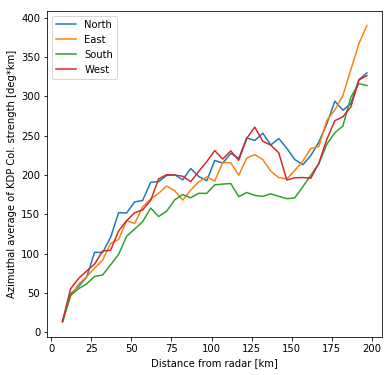

In [28]:
## Azimuthal average of kdp, zdr column strength
dist_radar_bins = np.arange(0,201,5)
kdp_ave_south = np.zeros(len(dist_radar_bins)-1)
zdr_ave_south = np.zeros(len(dist_radar_bins)-1)
kdp_ave_east = np.zeros(len(dist_radar_bins)-1)
zdr_ave_east = np.zeros(len(dist_radar_bins)-1)
kdp_ave_north = np.zeros(len(dist_radar_bins)-1)
zdr_ave_north = np.zeros(len(dist_radar_bins)-1)
kdp_ave_west = np.zeros(len(dist_radar_bins)-1)
zdr_ave_west = np.zeros(len(dist_radar_bins)-1)

x = storms['lon']
y = storms['lat']
south_east = y <= right_diagonal_m*(x-right_diagonal_a)+right_diagonal_b
north_west = y > right_diagonal_m*(x-right_diagonal_a)+right_diagonal_b
south_west = y <= left_diagonal_m*(x-left_diagonal_a)+left_diagonal_b
north_east = y > left_diagonal_m*(x-left_diagonal_a)+left_diagonal_b

for i in range(len(dist_radar_bins)-1):
    kdp_ave_south[i] = np.nanmean(storms['kdp_pet'][np.logical_and.reduce((storms['dist_from_radar'] >= dist_radar_bins[i],
                                                                          storms['dist_from_radar'] < dist_radar_bins[i+1],
                                                                          south_east, south_west))])
    zdr_ave_south[i] = np.nanmean(storms['zdr_pet'][np.logical_and.reduce((storms['dist_from_radar'] >= dist_radar_bins[i],
                                                                           storms['dist_from_radar'] < dist_radar_bins[i+1],
                                                                           south_east, south_west))])
    kdp_ave_west[i] = np.nanmean(storms['kdp_pet'][np.logical_and.reduce((storms['dist_from_radar'] >= dist_radar_bins[i],
                                                                          storms['dist_from_radar'] < dist_radar_bins[i+1],
                                                                          south_west, north_west))])
    zdr_ave_west[i] = np.nanmean(storms['zdr_pet'][np.logical_and.reduce((storms['dist_from_radar'] >= dist_radar_bins[i],
                                                                           storms['dist_from_radar'] < dist_radar_bins[i+1],
                                                                           south_west, north_west))])   
    kdp_ave_east[i] = np.nanmean(storms['kdp_pet'][np.logical_and.reduce((storms['dist_from_radar'] >= dist_radar_bins[i],
                                                                          storms['dist_from_radar'] < dist_radar_bins[i+1],
                                                                          south_east, north_east))])
    zdr_ave_east[i] = np.nanmean(storms['zdr_pet'][np.logical_and.reduce((storms['dist_from_radar'] >= dist_radar_bins[i],
                                                                           storms['dist_from_radar'] < dist_radar_bins[i+1],
                                                                           south_east, north_east))])
    kdp_ave_north[i] = np.nanmean(storms['kdp_pet'][np.logical_and.reduce((storms['dist_from_radar'] >= dist_radar_bins[i],
                                                                          storms['dist_from_radar'] < dist_radar_bins[i+1],
                                                                          north_east, north_west))])
    zdr_ave_north[i] = np.nanmean(storms['zdr_pet'][np.logical_and.reduce((storms['dist_from_radar'] >= dist_radar_bins[i],
                                                                           storms['dist_from_radar'] < dist_radar_bins[i+1],
                                                                           north_east, north_west))])                                
dist_radar_bins = (dist_radar_bins[:-1]+dist_radar_bins[1:])/2
#kdp_bias = interp1d(dist_radar_bins, kdp_ave, fill_value='extrapolate')
#zdr_bias = interp1d(dist_radar_bins, zdr_ave, fill_value='extrapolate')
plt.figure(figsize=(6,6))
plt.plot(dist_radar_bins, kdp_ave_north)
plt.plot(dist_radar_bins, kdp_ave_east)
plt.plot(dist_radar_bins, kdp_ave_south)
plt.plot(dist_radar_bins, kdp_ave_west)
plt.xlabel('Distance from radar [km]')
plt.ylabel('Azimuthal average of KDP Col. strength [deg*km]')
plt.legend(['North', 'East', 'South', 'West'])

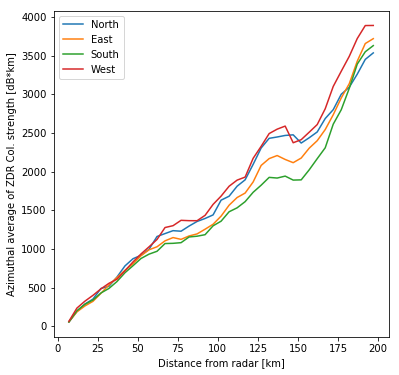

In [29]:
plt.figure(figsize=(6,6))
plt.plot(dist_radar_bins, zdr_ave_north)
plt.plot(dist_radar_bins, zdr_ave_east)
plt.plot(dist_radar_bins, zdr_ave_south)
plt.plot(dist_radar_bins, zdr_ave_west)
plt.xlabel('Distance from radar [km]')
plt.ylabel('Azimuthal average of ZDR Col. strength [dB*km]')
plt.legend(['North', 'East', 'South', 'West'])